In [1]:
!pip install Sastrawi

import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from sklearn import svm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.4 MB/s eta 0:00:00


# import dataset

In [2]:
komentar = pd.read_csv('dataset.csv')
komentar.head(10)

,author,comment,manual_sentiment
0,tutiherlina0,"Selamat untuk 10 pemenang, lanjutan terus kary...",positif
1,rstfl_studio,yahhh ga masuk 😢,negatif
2,artla_mh01,👏👏👏,positif
3,kristiana.yeti.5,"Selamat ya ,",positif
4,yaelahzan,spill karyanya,netral
5,nurohwatifari,Selamat yah...👏👏👏 semangatt teruss,positif
6,yayukhadijah,Boleh spill karya para 10 besarnya gak min,netral
7,ntzfa_,pengumuman pemenang nya kapan min?,positif
8,lagilagiidandiii_,Spil karyanya dong min👏,positif
9,herdianahena,👏👏👏👏👏,positif


# cleansing

In [3]:
def cleaningkomentar(komentar):

  komentar = re.sub(r'#[A-Za-z0-9]+',' ',komentar)
  komentar = re.sub(r"http\S+",' ',komentar)
  komentar = re.sub(r'[0-9]+',' ',komentar)
  komentar = re.sub(r"[-()\"#/@;:<>{}'+=~|.!?,_]", " ", komentar)
  #menghapus karakter tunggal
  komentar = re.sub(r"\b[a-zA-Z]\b", " ", komentar)
  komentar = komentar.strip(' ')
  return komentar
komentar['Cleaning']= komentar['comment'].apply(cleaningkomentar)


def clearEmoji(ulasan):
    return ulasan.encode('ascii', 'ignore').decode('ascii')
komentar['HapusEmoji']= komentar['Cleaning'].apply(clearEmoji)

def replaceTOM(ulasan):
    pola = re.compile(r'(.)\1{2,}', re.DOTALL)
    return pola.sub(r'\1', ulasan)
komentar['cleansing']= komentar['HapusEmoji'].apply(replaceTOM)

komentar[['comment','cleansing']]
komentar[['comment','cleansing']].to_csv('cleansing.csv', index=False,float_format='%.2f')

# case folding

In [4]:
def casefoldingText(komentar):
  komentar = komentar.lower()
  return komentar
komentar['CaseFolding']= komentar['cleansing'].apply(casefoldingText)
komentar[['cleansing','CaseFolding']]
komentar[['cleansing','CaseFolding']].to_csv('casefolding.csv', index=False)

# tokenizing

In [5]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
def tokenizingText(komentar):
  komentar = word_tokenize(komentar)
  return komentar
komentar['Tokenizing']= komentar['CaseFolding'].apply(tokenizingText)
komentar[['CaseFolding','Tokenizing']]
komentar[['CaseFolding','Tokenizing']].to_csv('tokenizing.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# stemming

In [6]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


def stemming(kalimat_baru):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    # Lakukan stemming pada setiap kata
    stemmed_words = [stemmer.stem(word) for word in kalimat_baru]
    return stemmed_words

komentar['Stemming_list'] = komentar['Tokenizing'].apply(stemming)

#merubah list ke str
komentar['Stemming'] = komentar['Stemming_list'].apply(' '.join)

#menampilkan data hasil stemming
komentar[['Tokenizing','Stemming']]
komentar[['Tokenizing','Stemming']].to_csv('stemming.csv', index=False)

# negasi handling

In [7]:
def handle_negation(kalimat_baru):
    negation_words = ["tidak", "bukan", "tak", "tiada", "jangan", "gak", "ga"]
    new_words = []
    prev_word_is_negation = False
    for word in kalimat_baru:
        if word in negation_words:
            new_words.append("tidak_")
            prev_word_is_negation = True
        elif prev_word_is_negation:
            new_words[-1] += word
            prev_word_is_negation = False
        else:
            new_words.append(word)
    return new_words
komentar['negasi'] = komentar['Stemming_list'].apply(handle_negation)
#menampilkan data hasil stemming
komentar[['Stemming','negasi']]
komentar[['Stemming','negasi']].to_csv('negasi.csv', index=False)

# word normalization

In [8]:
def convertToSlangword(komentar):
    kamusSlang = eval(open("slangwords.txt").read())
    pattern = re.compile(r'\b( ' + '|'.join (kamusSlang.keys())+r')\b')
    content = []
    for kata in komentar:
        filter_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata.lower())
        if filter_slang.startswith('tidak_'):
          kata_depan = 'tidak_'
          kata_belakang = kata[6:]
          kata_belakang_slang = pattern.sub(lambda x: kamusSlang[x.group()], kata_belakang.lower())
          kata_hasil = kata_depan + kata_belakang_slang
          content.append(kata_hasil)
        else:
          content.append(filter_slang)
    komentar = content
    return komentar

komentar['Formalisasi'] = komentar['negasi'].apply(convertToSlangword)
komentar[['negasi','Formalisasi']]
komentar[['negasi','Formalisasi']].to_csv('word normalization.csv', index=False)

# stopword removal

In [9]:
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Mengunduh daftar stopword dari NLTK
daftar_stopword = stopwords.words('indonesian')

# Menambahkan stopword tambahan
daftar_stopword.extend(["yg", "dg", "rt", "dgn", "ny", "d",'gb','ahk','g'])

# Membaca file teks stopword menggunakan pandas
txt_stopword = pd.read_csv("stopwords.txt", names=["stopwords"], header=None)

# Menggabungkan daftar stopword dari NLTK dengan daftar stopword dari file teks
daftar_stopword.extend(txt_stopword['stopwords'].tolist())

# Mengubah daftar stopword menjadi set untuk pencarian yang lebih efisien
daftar_stopword = set(daftar_stopword)

def stopwordText(words):
    cleaned_words = []
    for word in words:
        # Memisahkan kata dengan tambahan "tidak_"
        if word.startswith("tidak_"):
            cleaned_words.append(word[:5])
            cleaned_words.append(word[6:])
        elif word not in daftar_stopword:
            cleaned_words.append(word)
    return cleaned_words

komentar['Stopword_list'] = komentar['Formalisasi'].apply(stopwordText)
#merubah list ke str
komentar['Stopword_Removal'] = komentar['Stopword_list'].apply(' '.join)
komentar[['Formalisasi','Stopword_Removal']].to_csv('stopword.csv', index=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Save Clean Dataset

In [10]:
komentar.to_csv('dataset_bersih.csv',index=False)

In [11]:
data = pd.read_csv('dataset_bersih.csv')
data = data[data['Tokenizing'] != '[]']
data = data[data['Stopword_list'] != '[]']
data.to_csv('dataset_bersih.csv',index=False)

# Translate

In [12]:
#Install Library Googletrans
!pip3 install googletrans==3.1.0a0
import googletrans
from googletrans import *
translator = googletrans.Translator()
df = pd.read_csv('dataset_bersih.csv')
df['Stopword_Removal'] = df['Stopword_Removal'].astype(str) #Ubah tipe data ke string
df['English_Comment'] = df['Stopword_Removal'].apply(translator.translate, src='auto', dest='en').apply(getattr, args=('text',))
df
#Simpan data terjemahan inggris ke file csv
df.to_csv('dataset_bersih_ing.csv')

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16351 sha256=2c09771443c799eb4a31274f1f674fdca30964f813296bda66b7adf8a9bd257b
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling ch

# VADER and Classification

In [13]:
import pandas as pd
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Inisialisasi SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Fungsi untuk mendapatkan label berdasarkan nilai sentimen
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positif'
    elif score <= -0.05:
        return 'negatif'
    else:
        return 'netral'

# Membaca file CSV dengan kolom 'ulasan'
data = pd.read_csv('dataset_bersih_ing.csv')

# Membuat kolom baru untuk menyimpan hasil pelabelan
data['predicted_sentimen'] = ""

# Melakukan pelabelan pada setiap ulasan
for index, row in data.iterrows():
    komentar = row['English_Comment']
    sentiment_score = sia.polarity_scores(komentar)['compound']
    label = get_sentiment_label(sentiment_score)
    data.at[index, 'predicted_sentimen'] = label

# Menyimpan hasil pelabelan ke file CSV
output_path = 'hasil_prediksi_sentimen.csv'  # Ganti dengan path tujuan Anda
data.to_csv(output_path, index=False)

print("Pelabelan selesai. Hasil disimpan di:", output_path)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Pelabelan selesai. Hasil disimpan di: hasil_prediksi_sentimen.csv


# Visualization

jumlah sentimen :
positif    330
netral     197
negatif     11
Name: predicted_sentimen, dtype: int64


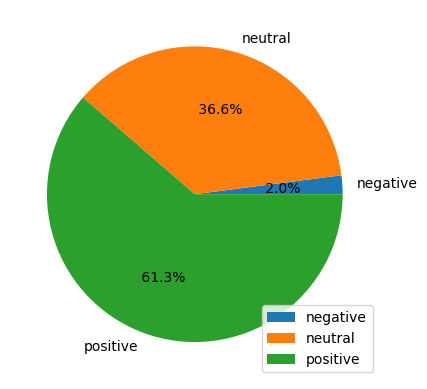

In [14]:
# melihat jumlah kelas sentimen
komentar = pd.read_csv('hasil_prediksi_sentimen.csv')
Jumlah_sentimen = komentar['predicted_sentimen'].value_counts()
print("jumlah sentimen :")
print(Jumlah_sentimen)
# menampilkan dalam bentuk plot diagram
import matplotlib.pyplot as plt
%matplotlib inline
labels = ['negative' , 'neutral', 'positive']
plt.pie(komentar.groupby('predicted_sentimen')['predicted_sentimen'].count(), autopct=" %.1f%% " ,labels=labels)
plt.legend()
plt.show()

# Negatif Sentimen

In [15]:
# Membuat DataFrame baru hanya dengan sentimen negatif
sentimen_negatif = komentar[komentar['predicted_sentimen'] == 'negatif']

# Menyimpan DataFrame baru ke dalam file CSV jika diperlukan
sentimen_negatif.to_csv('sentimen_negatif.csv', index=False)

# Wordcloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


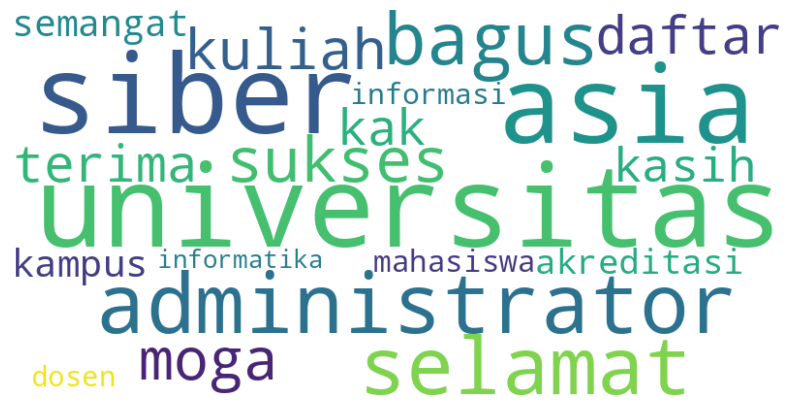

Kata: 'universitas', Jumlah Kemunculan: 116
Kata: 'siber', Jumlah Kemunculan: 108
Kata: 'asia', Jumlah Kemunculan: 107
Kata: 'administrator', Jumlah Kemunculan: 57
Kata: 'selamat', Jumlah Kemunculan: 56
Kata: 'bagus', Jumlah Kemunculan: 53
Kata: 'sukses', Jumlah Kemunculan: 39
Kata: 'moga', Jumlah Kemunculan: 34
Kata: 'kuliah', Jumlah Kemunculan: 34
Kata: 'daftar', Jumlah Kemunculan: 33
Kata: 'terima', Jumlah Kemunculan: 32
Kata: 'kak', Jumlah Kemunculan: 30
Kata: 'kasih', Jumlah Kemunculan: 28
Kata: 'kampus', Jumlah Kemunculan: 27
Kata: 'semangat', Jumlah Kemunculan: 26
Kata: 'akreditasi', Jumlah Kemunculan: 24
Kata: 'mahasiswa', Jumlah Kemunculan: 24
Kata: 'informasi', Jumlah Kemunculan: 22
Kata: 'dosen', Jumlah Kemunculan: 21
Kata: 'informatika', Jumlah Kemunculan: 17


In [68]:
from tkinter import END
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import Counter

def generate_wordcloud(text):
  global WordCloud
  global stopwords
  global Counter

  # Mengunduh daftar stopword dari NLTK
  daftar_stopword = stopwords.words('indonesian')

  # Menambahkan stopword tambahan
  stopwords_nltk = set(STOPWORDS)
  daftar_stopword.extend(["yg", "dg", "rt", "dgn", "ny", "d",'gb','ahk','g','nya','online', 'ratih', 'dm','aamiin'])
  daftar_stopword.extend(stopwords_nltk)

  # Membaca file teks stopword menggunakan pandas
  txt_stopword = pd.read_csv("stopwords.txt", names=["stopwords"], header=None)

  # Menggabungkan daftar stopword dari NLTK dengan daftar stopword dari file teks
  daftar_stopword.extend(txt_stopword['stopwords'].tolist())

  # Membagi teks menjadi kata-kata atau token
  text = text.split()

  # Menghitung frekuensi setiap kata
  final_text = Counter(text)

  # Menghapus stopwords dari data Counter
  final_text = {kata: jumlah for kata, jumlah in final_text.items() if kata.lower() not in daftar_stopword}

  # Mengambil 20 term tertinggi
  top_20_kata = Counter(final_text).most_common(20)

  # Membuat WordCloud dengan menggunakan Counter setelah stopwords dihilangkan
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_20_kata))

  # Menampilkan WordCloud
  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

    # Cetak 20 term tertinggi beserta jumlah kemunculannya
  for kata, jumlah in top_20_kata:
    print(f"Kata: '{kata}', Jumlah Kemunculan: {jumlah}")




# Menggabungkan semua kata pada kolom finalisasi komentar (Stopword_removal) menjadi satu teks
text = ' '.join(komentar['Stopword_Removal'].astype(str).values)

generate_wordcloud(text)



# Positive Sentiments Wordcloud

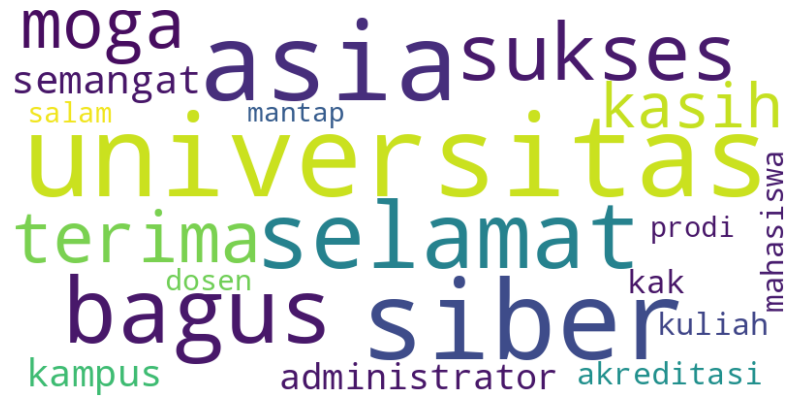

Kata: 'universitas', Jumlah Kemunculan: 85
Kata: 'siber', Jumlah Kemunculan: 80
Kata: 'asia', Jumlah Kemunculan: 79
Kata: 'selamat', Jumlah Kemunculan: 55
Kata: 'bagus', Jumlah Kemunculan: 53
Kata: 'sukses', Jumlah Kemunculan: 39
Kata: 'terima', Jumlah Kemunculan: 31
Kata: 'moga', Jumlah Kemunculan: 30
Kata: 'kasih', Jumlah Kemunculan: 28
Kata: 'semangat', Jumlah Kemunculan: 26
Kata: 'kampus', Jumlah Kemunculan: 23
Kata: 'administrator', Jumlah Kemunculan: 21
Kata: 'kak', Jumlah Kemunculan: 17
Kata: 'akreditasi', Jumlah Kemunculan: 16
Kata: 'kuliah', Jumlah Kemunculan: 16
Kata: 'mahasiswa', Jumlah Kemunculan: 15
Kata: 'dosen', Jumlah Kemunculan: 14
Kata: 'prodi', Jumlah Kemunculan: 13
Kata: 'salam', Jumlah Kemunculan: 13
Kata: 'mantap', Jumlah Kemunculan: 12


In [69]:
# Membuat subset dari DataFrame 'komentar' dengan sentimen positif
komentar_positif = komentar[komentar['predicted_sentimen'] == 'positif']
text = ' '.join(komentar_positif['Stopword_Removal'].astype(str).values)

generate_wordcloud(text)

# Netral Sentiments Wordcloud

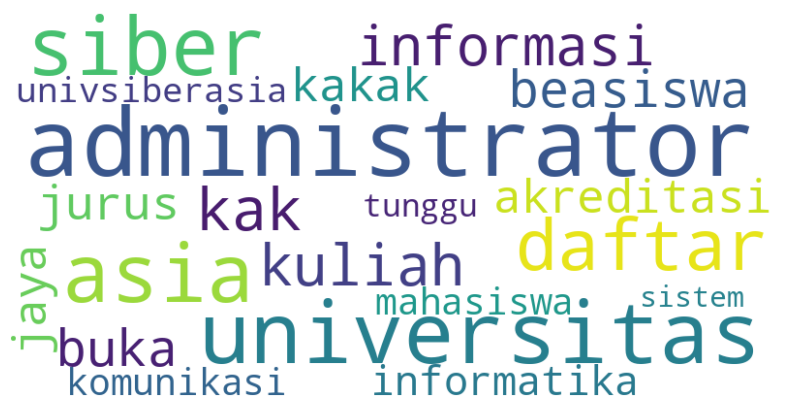

Kata: 'administrator', Jumlah Kemunculan: 34
Kata: 'universitas', Jumlah Kemunculan: 28
Kata: 'siber', Jumlah Kemunculan: 25
Kata: 'asia', Jumlah Kemunculan: 25
Kata: 'daftar', Jumlah Kemunculan: 19
Kata: 'kak', Jumlah Kemunculan: 13
Kata: 'kuliah', Jumlah Kemunculan: 12
Kata: 'informasi', Jumlah Kemunculan: 11
Kata: 'buka', Jumlah Kemunculan: 9
Kata: 'beasiswa', Jumlah Kemunculan: 9
Kata: 'jurus', Jumlah Kemunculan: 8
Kata: 'akreditasi', Jumlah Kemunculan: 8
Kata: 'kakak', Jumlah Kemunculan: 8
Kata: 'jaya', Jumlah Kemunculan: 8
Kata: 'informatika', Jumlah Kemunculan: 7
Kata: 'komunikasi', Jumlah Kemunculan: 7
Kata: 'mahasiswa', Jumlah Kemunculan: 7
Kata: 'univsiberasia', Jumlah Kemunculan: 7
Kata: 'tunggu', Jumlah Kemunculan: 6
Kata: 'sistem', Jumlah Kemunculan: 5


In [70]:
# Membuat subset dari DataFrame 'komentar' dengan sentimen netral
komentar_netral = komentar[komentar['predicted_sentimen'] == 'netral']
text = ' '.join(komentar_netral['Stopword_Removal'].astype(str).values)

generate_wordcloud(text)

# Negative Sentiments Wordcloud

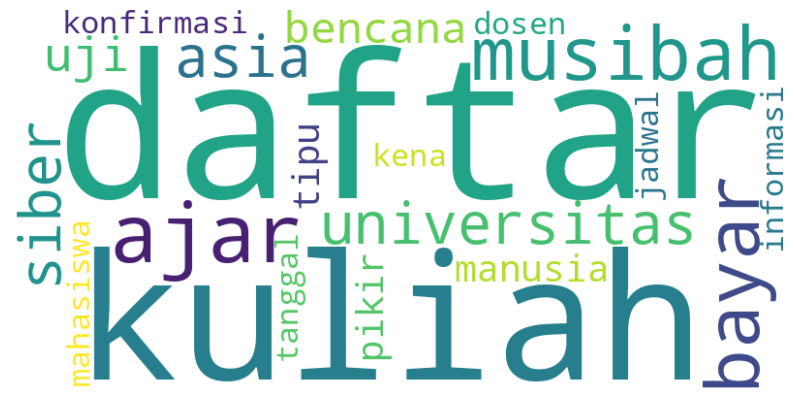

Kata: 'daftar', Jumlah Kemunculan: 8
Kata: 'kuliah', Jumlah Kemunculan: 6
Kata: 'ajar', Jumlah Kemunculan: 3
Kata: 'musibah', Jumlah Kemunculan: 3
Kata: 'bayar', Jumlah Kemunculan: 3
Kata: 'universitas', Jumlah Kemunculan: 3
Kata: 'siber', Jumlah Kemunculan: 3
Kata: 'asia', Jumlah Kemunculan: 3
Kata: 'uji', Jumlah Kemunculan: 2
Kata: 'bencana', Jumlah Kemunculan: 2
Kata: 'manusia', Jumlah Kemunculan: 2
Kata: 'pikir', Jumlah Kemunculan: 2
Kata: 'tipu', Jumlah Kemunculan: 2
Kata: 'konfirmasi', Jumlah Kemunculan: 2
Kata: 'kena', Jumlah Kemunculan: 2
Kata: 'mahasiswa', Jumlah Kemunculan: 2
Kata: 'informasi', Jumlah Kemunculan: 2
Kata: 'jadwal', Jumlah Kemunculan: 2
Kata: 'tanggal', Jumlah Kemunculan: 2
Kata: 'dosen', Jumlah Kemunculan: 2


In [71]:
# Membuat subset dari DataFrame 'komentar' dengan sentimen negatif
komentar_negatif = komentar[komentar['predicted_sentimen'] == 'negatif']
text = ' '.join(komentar_negatif['Stopword_Removal'].astype(str).values)

generate_wordcloud(text)

# Accuracy

In [72]:
# Hitung jumlah data yang diprediksi dengan benar
correct_predictions = (komentar['predicted_sentimen'] == komentar['manual_sentiment']).sum()
total_predictions = len(komentar)

# Hitung akurasi
accuracy = correct_predictions / total_predictions

print(f"Jumlah Prediksi Benar: {correct_predictions}")
print(f"Jumlah Prediksi: {total_predictions}")
print(f"Jumlah Prediksi Benar / Jumlah Prediksi: {correct_predictions/total_predictions}")
print(f"Presentase Akurasi: {accuracy * 100:.2f}%")

Jumlah Prediksi Benar: 490
Jumlah Prediksi: 538
Jumlah Prediksi Benar / Jumlah Prediksi: 0.9107806691449815
Presentase Akurasi: 91.08%


# Differences

In [73]:
# lihat perbedaan hasil prediksi dengan manual labeling
komentar['perbedaan'] = komentar['predicted_sentimen'] != komentar['manual_sentiment']
differences_df = komentar[komentar['perbedaan']]
differences_df = komentar.loc[komentar['predicted_sentimen'] != komentar['manual_sentiment']]
differences_df = komentar.query("predicted_sentimen != manual_sentiment")
differences_df.to_csv('perbedaan_sentimen.csv', index=False)
print(differences_df)

     Unnamed: 0                    author  \
1             1              rstfl_studio   
7             7         lagilagiidandiii_   
34           34                muhnadhinf   
35           35                  zalhijal   
45           45                 evhlyin26   
70           70                  loxbuyer   
103         103                    vnbo67   
106         106                restusucii   
107         107                 ari.riari   
108         108                    _kaa63   
117         117                  raulll_q   
126         126                   and_adk   
127         127              ketykornelia   
134         134  efthariena_ishak_jenahir   
141         141             nabillanita_x   
161         161             tekukplatbesi   
162         162                   maya_hw   
164         164              m2msg_sk_skg   
167         167                michatan96   
204         204               jufrishidik   
220         220                   efrid01   
225       